<a href="https://colab.research.google.com/github/yash2998chhabria/Rnn-Nlp/blob/master/Copy_of_bidirectional_Multilayer_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spacy

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [2]:
import spacy 

spacy.__version__

'2.2.4'

In [3]:
import torch
import torchtext
from torchtext import datasets

import re
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

### Twitter Sentiment Analysis Dataset
Source: http://thinknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/

In [4]:
tweets = pd.read_csv('/content/drive/My Drive/depressionrnn/test1307.csv', error_bad_lines = False)

tweets = tweets.head(50000)
tweets.head()

,sentence,condition
0,Scotland Yard took photographs of the man wear...,0.0
1,I have learnt to mask the bad sides.,1.0
2,"The children were asleep and all was well, exc...",0.0
3,"making a mockery of me\r\nive been humiliated,...",1.0
4,(Like usual I don't know Icelandic so I'm tryi...,0.0


In [5]:
tweets = tweets.rename(index = str, columns = {'sentence': 'SentimentText', 'condition': 'Sentiment'})

tweets.head()


,SentimentText,Sentiment
0,Scotland Yard took photographs of the man wear...,0.0
1,I have learnt to mask the bad sides.,1.0
2,"The children were asleep and all was well, exc...",0.0
3,"making a mockery of me\r\nive been humiliated,...",1.0
4,(Like usual I don't know Icelandic so I'm tryi...,0.0


In [6]:
tweets=tweets.dropna()

The dataframe consists of 4 columns and we want to use only ‘Sentiment’ and ‘SentimentText’.

In [7]:
tweets.shape

(1306, 2)

In [8]:
tweets['Sentiment'].unique()

array([0., 1.])

In [9]:
tweets.Sentiment.value_counts()

0.0    776
1.0    530
Name: Sentiment, dtype: int64

[Text(0.5, 0, 'Labels')]

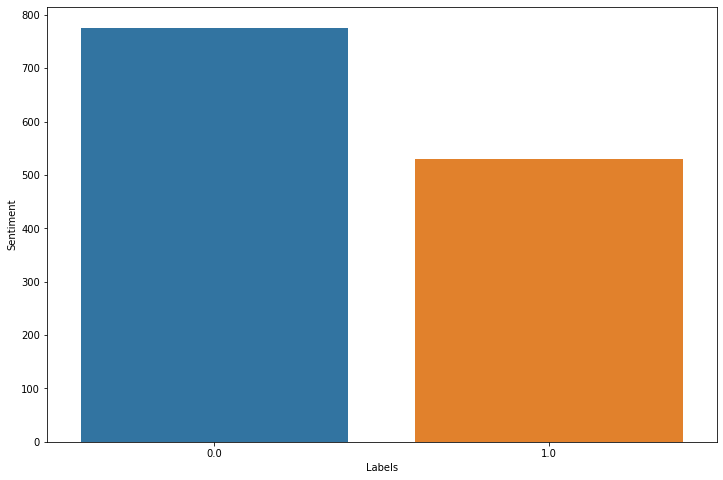

In [25]:
fig = plt.figure(figsize=(12, 8))

ax = sns.barplot(x=tweets.Sentiment.unique(), y=tweets.Sentiment.value_counts())

ax.set(xlabel='Labels')

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(tweets, test_size=0.2, random_state=42)

In [12]:
train.reset_index(drop=True), test.reset_index(drop=True)

(                                          SentimentText  Sentiment
 0     I felt something that wasnt completely terribl...        1.0
 1                              Fine I'll buzz it short.        0.0
 2     Was he running from a perceived threat to his ...        0.0
 3     All fun times, but when it gets to night in re...        1.0
 4     just dont give up\r\n\r\n3. consume small amou...        0.0
 ...                                                 ...        ...
 1039                  And if so, why didn't I see them?        1.0
 1040             No one for me to visit or to visit me.        1.0
 1041  What happened to the years?I've been lost in d...        1.0
 1042  I know this is gonna be harsh but I envy peopl...        1.0
 1043                         Why would you argument so?        0.0
 
 [1044 rows x 2 columns],
                                          SentimentText  Sentiment
 0    I have never been that low before, during thos...        1.0
 1    It's strange to 

In [13]:

train

,SentimentText,Sentiment
989,I felt something that wasnt completely terribl...,1.0
10,Fine I'll buzz it short.,0.0
147,Was he running from a perceived threat to his ...,0.0
346,"All fun times, but when it gets to night in re...",1.0
411,just dont give up\r\n\r\n3. consume small amou...,0.0
...,...,...
1095,"And if so, why didn't I see them?",1.0
1131,No one for me to visit or to visit me.,1.0
1295,What happened to the years?I've been lost in d...,1.0
860,I know this is gonna be harsh but I envy peopl...,1.0


In [14]:
train.shape, test.shape

((1044, 2), (262, 2))

In [15]:
train.to_csv('/content/drive/My Drive/depressionrnn/train_tweets.csv', index=False)
test.to_csv('/content/drive/My Drive/depressionrnn/test_tweets.csv', index=False)

#### defining a funtion to clean the tweets by removing non alphanumeric character and links 

In [16]:
def tweet_clean(text):
    
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text) 
    text = re.sub(r'https?:/\/\S+', ' ', text) 
    
    return text.strip()

####  The tweet column (‘SentimentText’) needs processing and tokenization, so that it can be converted into indices.

In [17]:
nlp = spacy.load('en', disable=['parser', 'tagger', 'ner'])

def tokenizer(s): 
    return [w.text.lower() for w in nlp(tweet_clean(s))]

In [18]:
TEXT = torchtext.data.Field(tokenize = tokenizer)

LABEL = torchtext.data.LabelField(dtype = torch.float)

In [19]:
datafields = [('SentimentText', TEXT),('Sentiment', LABEL)]

#### We create torchtext dataset,TabularDataset which is specially designed to read csv and tsv files and process them. It is a wrapper around pytorch Dataset with additional features. 

In [20]:
trn, tst = torchtext.data.TabularDataset.splits(path = '/content/drive/My Drive/depressionrnn', 
                                                train = 'train_tweets.csv',
                                                test = 'test_tweets.csv',    
                                                format = 'csv',
                                                skip_header = True,
                                                fields = datafields)

In [21]:
print(f'Number of training examples: {len(trn)}')
print(f'Number of testing examples: {len(tst)}')

Number of training examples: 1044
Number of testing examples: 262


In [22]:
vars(trn.examples[0])

{'Sentiment': '1.0',
 'SentimentText': ['i',
  'felt',
  'something',
  'that',
  'was',
  'nt',
  'completely',
  'terrible',
  'but',
  'it',
  'went',
  'away',
  'overnight']}

In [23]:
vars(tst.examples[0])

{'Sentiment': '1.0',
 'SentimentText': ['i',
  'have',
  'never',
  'been',
  'that',
  'low',
  'before',
  'during',
  'those',
  'months',
  'i',
  'had',
  'been',
  'hospitalized',
  'attempted',
  'suicide',
  'on',
  'multiple',
  'occasions',
  'and',
  'felt',
  'nothing',
  'except',
  'the',
  'urge',
  'to',
  'be',
  'gone']}

#### Load pretrained word vectors and build vocabulary
Now, instead of having our word embeddings initialized randomly, they are initialized with these pre-trained vectors. We get these vectors simply by specifying which vectors we want and passing it as an argument to build_vocab. TorchText handles downloading the vectors and associating them with the correct words in our vocabulary.

In [24]:
TEXT.build_vocab(trn, max_size=25000,
                 vectors="glove.6B.100d",
                 unk_init=torch.Tensor.normal_)

LABEL.build_vocab(trn)

.vector_cache/glove.6B.zip: 862MB [06:27, 2.22MB/s]                          
100%|█████████▉| 398618/400000 [00:23<00:00, 16409.88it/s]

In [26]:
print(TEXT.vocab.freqs.most_common(50))

[('i', 933), ('the', 748), ('to', 563), ('and', 557), ('a', 403), ('of', 319), ('in', 294), ('my', 241), ('that', 238), ('was', 234), ('it', 220), ('t', 170), ('me', 168), ('for', 161), ('but', 159), ('m', 157), ('s', 154), ('this', 150), ('on', 144), ('he', 143), ('is', 134), ('have', 130), ('so', 118), ('with', 111), ('just', 110), ('had', 109), ('not', 104), ('at', 98), ('be', 97), ('like', 97), ('been', 87), ('you', 83), ('from', 81), ('his', 77), ('as', 75), ('she', 71), ('no', 70), ('up', 68), ('were', 66), ('about', 65), ('they', 65), ('out', 64), ('can', 64), ('get', 62), ('all', 61), ('or', 61), ('do', 59), ('david', 59), ('one', 59), ('her', 59)]


In [27]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'i', 'the', 'to', 'and', 'a', 'of', 'in', 'my']


In [28]:
print(LABEL.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7fce28312730>, {'0.0': 0, '1.0': 1})


#### Loading the data in batches
For data with variable length sentences torchtext provides BucketIterator() dataloader which is wrapper around pytorch Dataloader. 

In [29]:
train_iterator, test_iterator = torchtext.data.BucketIterator.splits(
                                (trn, tst),
                                batch_size = 64,
                                sort_key=lambda x: len(x.SentimentText),
                                sort_within_batch=False)

#### We'll be using a different RNN architecture called a Long Short-Term Memory (LSTM).

<b>torch.nn.embedding</b> -A simple lookup table that stores embeddings of a fixed dictionary and size.This module is often used to store word embeddings and retrieve them using indices. The input to the module is a list of indices, and the output is the corresponding word embeddings.


<b>LSTM</b> - Applies a multi-layer long short-term memory (LSTM) RNN to an input sequence.

<b>bidirectional</b> - an RNN processing the words in the sentence from the first to the last (a forward RNN), we have a second RNN processing the words in the sentence from the last to the first (a backward RNN). At time step $t$, the forward RNN is processing word $x_t$, and the backward RNN is processing word $x_{T-t+1}$.


<b>Dropout</b> - it works by randomly dropping out (setting to 0) neurons in a layer during a forward pass. The probability that each neuron is dropped out is set by a hyperparameter and each neuron with dropout applied is considered indepenently.This helps in regularization.


In [30]:
import torch.nn as nn

class RNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, 
                 output_dim, n_layers, bidirectional, dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers = n_layers, 
                           bidirectional = bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        
        self.dropout = nn.Dropout(dropout)

        
    def forward(self, text):
        
        embedded = self.dropout(self.embedding(text))
        
        output, hidden = self.rnn(embedded)
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
       
        return self.fc(hidden.squeeze(0))

To ensure the pre-trained vectors can be loaded into the model, the EMBEDDING_DIM must be equal to that of the pre-trained GloVe vectors loaded earlier.

We get our pad token index from the vocabulary, getting the actual string representing the pad token from the field's pad_token attribute, which is pad by default.

In [31]:
input_dim = len(TEXT.vocab)

embedding_dim = 100

hidden_dim = 20
output_dim = 1

n_layers = 2
bidirectional = True

dropout = 0.5

In [32]:
model = RNN(input_dim, 
            embedding_dim, 
            hidden_dim, 
            output_dim, 
            n_layers, 
            bidirectional, 
            dropout)

In [33]:
model

RNN(
  (embedding): Embedding(3375, 100)
  (rnn): GRU(100, 20, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

We retrieve the embeddings from the field's vocab, and check they're the correct size, [vocab size, embedding dim]

In [34]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([3375, 100])


We then replace the initial weights of the embedding layer with the pre-trained embeddings.

In [35]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-1.3187,  0.1261,  0.6007,  ...,  0.4883, -0.0990, -1.7508],
        [-1.0207, -1.4380, -1.6308,  ...,  0.5947,  1.9670,  0.8700],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [ 0.7893,  0.6285, -0.4647,  ...,  0.0823,  0.8793, -0.0854],
        [-0.7497,  0.3603,  0.9107,  ...,  0.1232,  0.2503, -0.1138],
        [ 0.1238,  0.0467,  0.1646,  ..., -0.1151,  0.2209, -0.4480]])

As our < unk > and < pad > token aren't in the pre-trained vocabulary they have been initialized using unk_init (an $\mathcal{N}(0,1)$ distribution) when building our vocab. It is preferable to initialize them both to all zeros to explicitly tell our model that, initially, they are irrelevant for determining sentiment.

In [36]:
unk_idx = TEXT.vocab.stoi[TEXT.unk_token]
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [ 0.7893,  0.6285, -0.4647,  ...,  0.0823,  0.8793, -0.0854],
        [-0.7497,  0.3603,  0.9107,  ...,  0.1232,  0.2503, -0.1138],
        [ 0.1238,  0.0467,  0.1646,  ..., -0.1151,  0.2209, -0.4480]])


#### Train the Model

We use Adam optimizer and loss function is BCEWithLogitLoss 

In [37]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()

#### We define a function for training our model
as we are now using dropout, we must remember to use model.train() to ensure the dropout is "turned on" while training.

In [38]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.SentimentText).squeeze(1)
        
        loss = criterion(predictions, batch.Sentiment)
        
        rounded_preds = torch.round(torch.sigmoid(predictions))
        correct = (rounded_preds == batch.Sentiment).float() 
        
        acc = correct.sum() / len(correct)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [39]:
num_epochs = 25

for epoch in range(num_epochs):
     
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% |')

| Epoch: 01 | Train Loss: 0.680 | Train Acc: 57.46% |
| Epoch: 02 | Train Loss: 0.655 | Train Acc: 60.51% |
| Epoch: 03 | Train Loss: 0.629 | Train Acc: 65.70% |
| Epoch: 04 | Train Loss: 0.585 | Train Acc: 70.15% |
| Epoch: 05 | Train Loss: 0.524 | Train Acc: 74.17% |
| Epoch: 06 | Train Loss: 0.478 | Train Acc: 76.10% |
| Epoch: 07 | Train Loss: 0.444 | Train Acc: 79.65% |
| Epoch: 08 | Train Loss: 0.433 | Train Acc: 79.93% |
| Epoch: 09 | Train Loss: 0.430 | Train Acc: 79.80% |
| Epoch: 10 | Train Loss: 0.396 | Train Acc: 82.21% |
| Epoch: 11 | Train Loss: 0.372 | Train Acc: 84.06% |
| Epoch: 12 | Train Loss: 0.353 | Train Acc: 85.57% |
| Epoch: 13 | Train Loss: 0.364 | Train Acc: 84.30% |
| Epoch: 14 | Train Loss: 0.350 | Train Acc: 84.82% |
| Epoch: 15 | Train Loss: 0.336 | Train Acc: 86.12% |
| Epoch: 16 | Train Loss: 0.298 | Train Acc: 88.51% |
| Epoch: 17 | Train Loss: 0.303 | Train Acc: 88.84% |
| Epoch: 18 | Train Loss: 0.274 | Train Acc: 89.94% |
| Epoch: 19 | Train Loss: 0.

### Testing the model

In [40]:
epoch_loss = 0
epoch_acc = 0

model.eval()

with torch.no_grad():

    for batch in test_iterator:

        predictions = model(batch.SentimentText).squeeze(1)

        loss = criterion(predictions, batch.Sentiment)

        rounded_preds = torch.round(torch.sigmoid(predictions))
        correct = (rounded_preds == batch.Sentiment).float() 
        
        acc = correct.sum()/len(correct)

        epoch_loss += loss.item()
        epoch_acc += acc.item()


test_loss = epoch_loss / len(test_iterator)
test_acc = epoch_acc / len(test_iterator)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.543 | Test Acc: 80.10%


#### User Input
We can now use our model to predict the sentiment of any sentence we give it.As it has been trained on tweets, the sentences provided should in a positive or a negative context.

We are expecting tweets with a negative sentiment to return a value close to 1 and positive tweets to return a value close to 0


In [ ]:
sentence = 'ive started to isolate myself from other people'

In [ ]:
tokenized = [tok.text for tok in nlp.tokenizer(sentence)]

In [ ]:
indexed = [TEXT.vocab.stoi[t] for t in tokenized]

In [ ]:
tensor = torch.LongTensor(indexed)

In [ ]:
tensor = tensor.unsqueeze(1)

In [ ]:
prediction = torch.sigmoid(model(tensor))

In [ ]:
prediction.item()

0.9590845704078674

In [ ]:
torch.save(model, '/content/drive/My Drive/depressionrnn/eightytwo.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
model = torch.load('/content/drive/My Drive/depressionrnn/eightytwo.pt')
model.eval()

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


RNN(
  (embedding): Embedding(2732, 100)
  (rnn): GRU(100, 20, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0121,  0.0084,  0.0072,  ..., -0.0214,  0.0021,  0.0088],
         [-0.0465,  0.6516,  0.5970,  ..., -0.3768,  0.0361,  0.8100],
         ...,
         [-0.9414, -0.3731,  0.0856,  ...,  0.5145,  0.6110,  0.2623],
         [-0.0049,  0.2128,  0.2771,  ..., -0.7220, -0.2222, -0.7113],
         [ 0.1604,  0.0406,  0.2770,  ..., -0.0563,  0.1611, -0.4086]],
        requires_grad=True), Parameter containing:
 tensor([[-0.0260, -0.1328, -0.0900,  ...,  0.0154,  0.1880, -0.1659],
         [ 0.2192, -0.2068,  0.1037,  ...,  0.2077, -0.0103,  0.1045],
         [ 0.1496,  0.1885, -0.1441,  ...,  0.1054,  0.1378,  0.0093],
         ...,
         [ 0.0652,  0.0515,  0.0417,  ..., -0.2111, -0.1928, -0.1890],
         [-0.2067, -0.0950,  0.1700,  ...,  0.0932, -0.0494, -0.1517],
         [-0.1024,  0.1381, -0.1033,  ..., -0.0849, -0.0933, -0.1329]],
        requires_grad=True), Parameter conta

Now We gotta build the second RNN to understand the relations between sentences


In [ ]:

from nltk.tokenize import sent_tokenize

In [ ]:
import nltk 
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
para = pd.read_csv('/content/drive/My Drive/depressionrnn/paradataset.csv')

In [ ]:
lmao=para[0:20]

In [ ]:
input_data = {'sentence':[],'condition':[]}


In [ ]:
for i in range(len(para)):
  sent_tokens = sent_tokenize(para.loc[i, "submission"])
  input_line=[]
  for sentence in sent_tokens:
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed)
    tensor = tensor.unsqueeze(1)
    prediction = torch.sigmoid(model(tensor))
    input_line.append(prediction.item())
  input_data['sentence'].append(input_line)
  input_data['condition'].append(para.loc[i, "condition"])
  



In [ ]:
l=0
m=0
for i in range(len(para)):
  sent_tokens = sent_tokenize(para.loc[i, "submission"])
  l=l+len(sent_tokens)
m=l/i

In [ ]:
m

35.506864988558355

In [ ]:
vec_sentence = {}

In [ ]:
for i in range(len(para)):
  sent_tokens = sent_tokenize(para.loc[i, "submission"])
  for i in range(len(sent_tokens)):
    tokenized = [tok.text for tok in nlp.tokenizer(sent_tokens[i])]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed)
    tensor = tensor.unsqueeze(1)
    prediction = torch.sigmoid(model(tensor))
    vec_sentence.setdefault(i,[]).append(prediction.item())
  if i<580:
    for i in range(i+1,580):
      vec_sentence.setdefault(i,[]).append(0.0)

In [ ]:
vec_sent = pd.DataFrame(vec_sentence)

In [ ]:
average_vec_sent=vec_sent.iloc[:,0:36]

In [ ]:
average_vec_sent.sample(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
937,0.028025,0.081970,0.018994,0.012862,0.015752,0.013400,0.017066,0.013045,0.013256,0.262223,0.015231,0.011691,0.043369,0.039004,0.05912,0.010286,0.013013,0.017844,0.010274,0.010663,0.01253,0.015656,0.011054,0.070824,0.015913,0.018429,0.01183,0.014299,0.01082,0.01339,0.010616,0.034037,0.018488,0.0133,0.010109,0.120025
1737,0.335660,0.906271,0.958230,0.976691,0.254853,0.960349,0.095552,0.879995,0.580362,0.933612,0.968061,0.974498,0.835673,0.940369,0.94068,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000


mean value of number of sentences = 36

In [ ]:
data_para_vectors = pd.DataFrame.from_dict(input_data)

In [ ]:
sent_tokens = sent_tokenize("") 


In [ ]:
input_data = []
sent_tokens

['i am fed up with my life.',
 'There is nothing much left.',
 'I want to die.',
 'i like taking  walks by the  beach']

In [ ]:
for sentence in sent_tokens:
  tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
  indexed = [TEXT.vocab.stoi[t] for t in tokenized]
  tensor = torch.LongTensor(indexed)
  tensor = tensor.unsqueeze(1)
  prediction = torch.sigmoid(model(tensor))
  input_data.append(prediction.item())
  


In [ ]:
input_data

[0.9255887269973755,
 0.8959446549415588,
 0.9133660793304443,
 0.11528420448303223]

In [ ]:
data_para_vectors

,sentence,condition
0,"[0.023430433124303818, 0.10041609406471252, 0....",0
1,"[0.7287686467170715, 0.13594579696655273, 0.07...",1
2,"[0.019319090992212296, 0.8115354180335999, 0.0...",0
3,"[0.9652117490768433, 0.9601704478263855, 0.974...",1
4,"[0.01882638968527317, 0.017171267420053482, 0....",0
...,...,...
1744,"[0.02131967432796955, 0.021098053082823753, 0....",0
1745,"[0.021219639107584953, 0.0192734282463789, 0.0...",0
1746,"[0.18058808147907257, 0.8963363170623779, 0.93...",1
1747,"[0.2600974440574646, 0.018560275435447693, 0.0...",0


In [ ]:
data_para_vectors.to_csv('/content/drive/My Drive/depressionrnn/para_vectors.csv', index=False)

In [ ]:
data_para_vectors = pd.read_csv('/content/drive/My Drive/depressionrnn/para_vectors.csv')

In [ ]:
to_mer = data_para_vectors.iloc[:,1:]

In [ ]:
to_mer

,condition
0,0
1,1
2,0
3,1
4,0
...,...
1744,0
1745,0
1746,1
1747,0


In [ ]:
average_vec_sent

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,0.021249,0.029183,0.009153,0.863360,0.437762,0.027893,0.034607,0.009567,0.539730,0.023512,0.010532,0.073112,0.032779,0.013092,0.015442,0.016392,0.055576,0.015903,0.011706,0.011917,0.014009,0.013470,0.077795,0.016448,0.687319,0.027469,0.062830,0.017083,0.335660,0.133792,0.470579,0.015406,0.017100,0.034288,0.015089,0.497672
1,0.806606,0.128510,0.136395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.013921,0.856608,0.015094,0.032395,0.958026,0.903783,0.643045,0.772588,0.973150,0.067712,0.273345,0.818307,0.206419,0.153157,0.766966,0.018340,0.025191,0.009675,0.019293,0.249056,0.024023,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.942060,0.982114,0.983963,0.036931,0.643927,0.967281,0.946222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.013459,0.011142,0.014239,0.014808,0.021258,0.023457,0.014128,0.015280,0.010230,0.010001,0.015189,0.011412,0.015431,0.017493,0.012073,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,0.016779,0.016226,0.015499,0.013974,0.715402,0.013519,0.011302,0.012160,0.965153,0.015847,0.861451,0.021216,0.095369,0.019180,0.010733,0.038995,0.018170,0.019020,0.364901,0.010777,0.024120,0.018600,0.009852,0.026009,0.149471,0.045852,0.017224,0.012048,0.024373,0.017340,0.150561,0.013599,0.010900,0.013412,0.027110,0.011038
1743,0.014215,0.009749,0.015046,0.024823,0.017891,0.011946,0.011123,0.013225,0.010650,0.013751,0.011576,0.012770,0.010118,0.013741,0.032768,0.251493,0.026829,0.011291,0.009629,0.013361,0.019585,0.109740,0.011663,0.026420,0.016733,0.014017,0.015811,0.016686,0.012995,0.012610,0.019966,0.016812,0.019783,0.013839,0.033524,0.024873
1744,0.253411,0.627633,0.968265,0.032800,0.768215,0.532675,0.935778,0.015314,0.154825,0.015683,0.014456,0.116663,0.119161,0.099314,0.021685,0.894721,0.019328,0.054429,0.774793,0.811992,0.046720,0.015591,0.013781,0.759258,0.015267,0.152117,0.928234,0.013049,0.040625,0.031172,0.013982,0.107106,0.074915,0.969812,0.916486,0.016836
1745,0.343709,0.010765,0.044594,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
sent_numeric = pd.merge(to_mer,average_vec_sent,left_index=True,right_index=True)

In [ ]:
sent_numeric.sample(20)

,condition,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
1105,0,0.009367,0.012783,0.022719,0.011057,0.024844,0.059161,0.022686,0.020094,0.014623,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1363,1,0.971507,0.034623,0.096926,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
72,1,0.019303,0.016513,0.835452,0.376689,0.909730,0.353970,0.534320,0.458479,0.058625,0.025330,0.354170,0.601579,0.915218,0.325215,0.017765,0.875673,0.850846,0.129917,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
667,1,0.335660,0.535987,0.961520,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
154,1,0.443714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
467,1,0.975443,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
59,1,0.943144,0.969009,0.978386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1456,1,0.094357,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1614,1,0.035284,0.014343,0.431196,0.560822,0.280693,0.041694,0.186130,0.955176,0.078177,0.018452,0.020039,0.013777,0.016458,0.017221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
432,0,0.026609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
sent_numeric.to_csv('/content/drive/My Drive/depressionrnn/sent_numeric.csv',index=False)